<a href="https://colab.research.google.com/github/matt700395/RL_1st/blob/master/lunarlander_dqn_ver_korea_1_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install stable-baselines==2.7.0
!pip install box2d-py
!pip install gym pyvirtualdisplay
!apt install xvfb -y
!pip install piglet

from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
import random
import gym

# Set up display; otherwise rendering will fail for
# classic control type envs, apparently
import os
import Box2D
import pyglet
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'


# See https://github.com/ipython/ipython/issues/10045#issuecomment-522697219
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
#from IPython import display

import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


0

In [21]:
# 카트폴 예제에서의 DQN 에이전트
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False

        # 상태와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size

        # DQN 하이퍼파라미터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        #self.batch_size = 32
        #self.train_start = 1000
        self.batch_size = 5
        self.train_start = 5

        # 리플레이 메모리, 최대 크기 2000
        #self.memory = deque(maxlen=20000)
        self.memory = deque(maxlen=100)

        # 모델과 타깃 모델 생성
        self.model = self.build_model()
        self.target_model = self.build_model()

        # 타깃 모델 초기화
        self.update_target_model()


    # 상태가 입력, 큐함수가 출력인 인공신경망 생성
    def build_model(self):
        model = Sequential()
        model.add(Dense(30, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(30, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # 타깃 모델을 모델의 가중치로 업데이트
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []

        for i in range(self.batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])

        # 현재 상태에 대한 모델의 큐함수
        # 다음 상태에 대한 타깃 모델의 큐함수
        target = self.model.predict(states)
        target_val = self.target_model.predict(next_states)

        # 벨만 최적 방정식을 이용한 업데이트 타깃
        for i in range(self.batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * (
                    np.amax(target_val[i]))

        self.model.fit(states, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)


In [22]:
display = Display(visible=False, size=(400, 300))
display.start()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 30)                270       
                                                                 
 dense_37 (Dense)            (None, 30)                930       
                                                                 
 dense_38 (Dense)            (None, 4)                 124       
                                                                 
Total params: 1,324
Trainable params: 1,324
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 30)                270       
                                                                 
 dense_40 (Dense)           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


episode: 0   score: -24.860567644636504   memory length: 66   epsilon: 0.9398537314349842


episode: 1   score: -0.20154916479137341   memory length: 100   epsilon: 0.8666920568517111


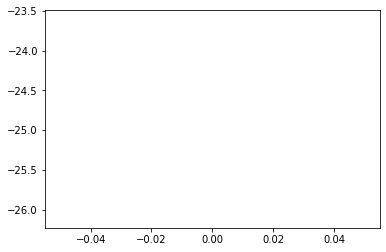

In [23]:
#EPISODES = 300
EPISODES = 1

# CartPole-v1 환경, 최대 타임스텝 수가 500
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# DQN 에이전트 생성
agent = DQNAgent(state_size, action_size)

scores, episodes = [], []

done_cnt = 0

for e in range(EPISODES+1):
    done = False
    score = 0
    cnt = 0
    # env 초기화
    state = env.reset() #== obs
    state = np.reshape(state, [1, state_size])

    #gif 저장관련1
    img = env.render(mode='rgb_array')
    n_images = 100
    images = []

    while not done:
      images.append(img)
      if agent.render:
        env.render()


      # 현재 상태로 행동을 선택
      action = agent.get_action(state)
      # 선택한 행동으로 환경에서 한 타임스텝 진행
      next_state, reward, done, position = env.step(action)
      next_state = np.reshape(next_state, [1, state_size])
      # 에피소드가 중간에 끝나면 -100 보상
      reward = reward if not done or score == 499 else -100

      #gif 저장관련2
      img = env.render(mode='rgb_array')

      # 리플레이 메모리에 샘플 <s, a, r, s'> 저장
      agent.append_sample(state, action, reward, next_state, done)
      # 매 타임스텝마다 학습
      if len(agent.memory) >= agent.train_start:
          agent.train_model()

      score += reward
      state = next_state
      #print(f'score : {score}, reward : {reward}')
      if done:
          reward += 10

          # 각 에피소드마다 타깃 모델을 모델의 가중치로 업데이트
          agent.update_target_model()

          score = score if score == 500 else score + 100
          # 에피소드마다 학습 결과 출력
          scores.append(score)
          episodes.append(e)
          print("episode:", e, "  score:", score, "  memory length:",
                len(agent.memory), "  epsilon:", agent.epsilon)

          # 이전 10개 에피소드의 점수 평균이 490보다 크면 학습 중단
          if np.mean(scores[-min(10, len(scores)):]) > 490:
              agent.model.save_weights("./lunar_lander_v2.h5")
              sys.exit()

    #gif 저장관련3
    imageio.mimwrite('./lander.gif',[np.array(img) for i, img in enumerate(images) if i%2 == 0],fps=29)

    if e % 100 == 0:
      agent.model.save_weights("./lunar_lander_v2.h5")
      pylab.plot(episodes, scores, 'b')
      pylab.savefig("./lunar_lander_v2.png")

In [19]:
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
import random
import gym

display = Display(visible=False, size=(400, 300))
display.start()

In [6]:
import imageio
import numpy as np

# Number of images to capture
n_images = 1200

images = []

# init a new episode
obs = env.reset()
# init the img var with the starting state of the env
img = env.render(mode='rgb_array')

for i in range(n_images):
  # At each step, append an image to list
  images.append(img)

  # Advance a step and render a new image
  action, _ = predict(obs)
  obs, _, _ ,_ = env.step(action)
  img = env.render(mode='rgb_array')

imageio.mimwrite('./lander.gif',
                [np.array(img) for i, img in enumerate(images) if i%2 == 0],
                fps=29)

NameError: ignored